# Experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import seaborn as sns
import kagglehub
import xgboost as xgb

import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

/home/martim/Traive/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess the data 

First, i'll setup the configs for the feature engineering

In [2]:
# Configurations used for the data processing and feature eng
config_id = 0 # id to separate run names with different configs on MLflow (change when testing new feat config dict)
experiment_name = 'Feature Selection - Regions' # Name to log on mlflow

configs = {
        "target_name": "AveragePrice", # Name of the target variable to predict
        "lags":[4, 8, 13, 26, 52], # The lags to be calculated for all the columns of the selected target region
        'target_regions':['Chicago', 'Detroit', 'SanFrancisco', 'StLouis'], # The regions i want to forecast
        "aux_regions": ['TotalUS', 'West', 'Midsouth', 'Northeast', 'Southeast', 'SouthCentral'], # "Exogenous" (auxiliary) regions to be used as inputs when predicting the target region
        "aux_features": ['AveragePrice_combined', 'TotalVolume_combined', # Features of the aux regions to include
                         '4046_combined', '4225_combined', '4770_combined', 
                         'TotalBags_combined', 'SmallBags_combined', 
                         'LargeBags_combined', 'XLargeBags_combined'],
        "aux_lags": [4, 8, 13, 26, 52], # The lags to be calculated of the aux features
    }

In [3]:
# Use the custom functions for loading and transforming the data 
import train_models
import data_processing
import feature_eng
df = data_processing.load_raw_data()
df = data_processing.preprocess_raw_data(df)
merge_df = data_processing.make_stage_1_data(configs)


# Feature importances

In this part I'll make some tests to see the relevance of the created features for the model.

For this I'll do an expanding window cross validation on the Train set only. The test set will only be used to evaluate the final model post feature selection predictions.

Since this is an exercise, to speed up execution and analysis a bit instead of calculating the feature importances in all regions I chose a sample of 4 regions: 'Chicago', 'Detroit', 'SanFrancisco' and 'StLouis'. In a real world case the ideal would be to test all of them

For experiment control and logging I'll be using mlflow

In [5]:
# Function to log the configs dict as parameters in MLflow
def log_dict_as_params(dictionary, prefix=""):
    for key, value in dictionary.items():
        param_name = f"{prefix}{key}"
        if isinstance(value, list):
            value = ','.join(map(str, value))  # Convert list to comma-separated string
        mlflow.log_param(param_name, value)

In [51]:
mlflow.set_tracking_uri("http://localhost:5000")  # Tracking server
mlflow.set_experiment(experiment_name)

# Loop over each region
with mlflow.start_run(run_name=f"Feature configs: {config_id}"):
    log_dict_as_params(configs)

    for region in configs['target_regions']:
        print(f'Trainning: {region}')
    
        # Load model ready data with the lags and features specified in the configs
        X, y, dates = feature_eng.make_stage_2_data(merge_df, region, configs)
        # For this we will 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Start a run for each region
        with mlflow.start_run(run_name=f"Region: {region}", nested=True) as region_run:
            mlflow.log_param("region", region)
            
            # Expanding window CV.
            tscv = TimeSeriesSplit(n_splits=5)
            fold_mse = []
            fold_mape = []
            
            # Loop over the folds of the expanding window CV
            for fold, (train_cv_index, val_cv_index) in enumerate(tscv.split(X_train)):
                X_train_cv, X_val_cv = X_train.iloc[train_cv_index], X_train.iloc[val_cv_index]
                y_train_cv, y_val_cv = y_train.iloc[train_cv_index], y_train.iloc[val_cv_index]
                
                # params = {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 5}
                params = {}
                model = xgb.XGBRegressor(**params)
                model.fit(X_train_cv, y_train_cv)
                
                # Make predictions and compute performance
                y_pred_cv = model.predict(X_val_cv)

                fold_mse.append(mean_squared_error(y_val_cv, y_pred_cv))
                fold_mape.append(mean_absolute_percentage_error(y_val_cv, y_pred_cv))

            # Log the last fold model
            mlflow.xgboost.log_model(model, artifact_path="last_fold_model")
            mlflow.log_params(params)
            # Log aggregated performance metrics for the region
            avg_mse = np.mean(fold_mse)
            avg_mape = np.mean(fold_mape)
            mlflow.log_metric("avg_cv_mse", avg_mse)
            mlflow.log_metric("avg_cv_mape", avg_mape)


            scores = model.get_booster().get_score()
            # Dict with all features, assigning 0 for importance if not used by the model
            full_scores = {feature: scores.get(feature, 0) for feature in X_train_cv.columns}

            # DataFrame for feature importances
            importance_df = pd.DataFrame({
                'Importance': list(full_scores.values())
            }, index = list(full_scores.keys()))

            csv_path = f"feature_importances_{region}.csv"
            importance_df.to_csv(csv_path)
            
            # Log as an artifact
            mlflow.log_artifact(csv_path)
            # Delete the CSV file after logging it
            if os.path.exists(csv_path):
                os.remove(csv_path)

Trainning: Chicago


/home/martim/Traive/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:13:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/10 17:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Region: Chicago at: http://localhost:5000/#/experiments/917453968468391848/runs/c3a38a1f4ad746a5827ec26e1ee2434e
🧪 View experiment at: http://localhost:5000/#/experiments/917453968468391848
Trainning: Detroit


/home/martim/Traive/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:13:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/10 17:13:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Region: Detroit at: http://localhost:5000/#/experiments/917453968468391848/runs/c12a898b168c42d1b25b584ee446ee12
🧪 View experiment at: http://localhost:5000/#/experiments/917453968468391848
Trainning: SanFrancisco


/home/martim/Traive/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:13:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/10 17:13:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Region: SanFrancisco at: http://localhost:5000/#/experiments/917453968468391848/runs/600f5a22ab7f4bd6ad2c88e94e841089
🧪 View experiment at: http://localhost:5000/#/experiments/917453968468391848
Trainning: StLouis


/home/martim/Traive/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:13:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/10 17:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Region: StLouis at: http://localhost:5000/#/experiments/917453968468391848/runs/04f5e46ae7824c6cbc960d1e1b504514
🧪 View experiment at: http://localhost:5000/#/experiments/917453968468391848
🏃 View run Feature configs: 0 at: http://localhost:5000/#/experiments/917453968468391848/runs/a4d2ad60d6b44be0ac6d957906a11d50
🧪 View experiment at: http://localhost:5000/#/experiments/917453968468391848


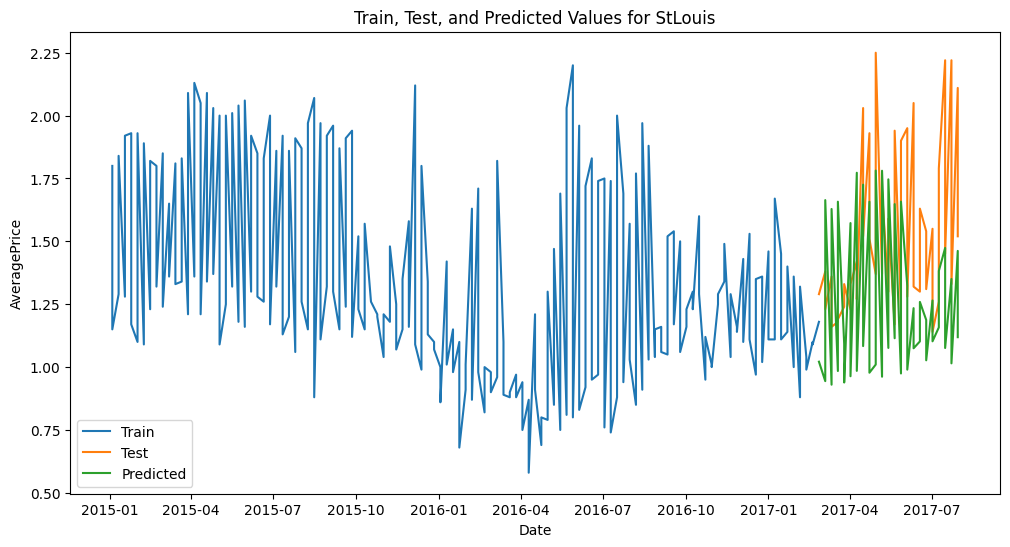

In [56]:
# Function to plot train, test, and predicted values
def plot_train_test_pred(dates, y_train, y_test, y_pred, target_name, region):
    plt.figure(figsize=(12, 6))
    plt.plot(dates.loc[y_train.index], y_train, label='Train')
    plt.plot(dates.loc[y_test.index], y_test, label='Test')
    plt.plot(dates.loc[y_test.index], y_pred, label='Predicted')
    plt.legend()
    plt.title(f"Train, Test, and Predicted Values for {region}")
    plt.xlabel("Date")
    plt.ylabel(target_name)
    plt.show()

plot_train_test_pred(dates, y_train_cv, y_val_cv, y_pred_cv, configs['target_name'], region)

In [ ]:
import matplotlib.pyplot as plt

all_regions_imp_df = pd.DataFrame()
# List all runs for the experiment
runs = mlflow.search_runs(experiment_names=[experiment_name])
parent_run = runs.loc[runs['tags.mlflow.parentRunId'].isnull()].iloc[0]
parent_id = parent_run['run_id']
child_runs = runs.loc[runs['tags.mlflow.parentRunId']==parent_id,:]

# Loop over each region to get feature importances
for index, run in child_runs.iterrows():
    run_id = run['run_id']
    region = run['params.region']
    
    # Download the artifact
    artifact_path = f"feature_importances_{region}.csv"
    local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)
    
    # Read the CSV file
    feat_importance_df = pd.read_csv(local_path, index_col=0)
    # Delete the CSV file after logging it
    if os.path.exists(csv_path):
        os.remove(csv_path)
    
    feat_importance_df = feat_importance_df.rename(columns={'Importance':region})

    # Append to the all_regions_imp_df DataFrame
    all_regions_imp_df = pd.concat([all_regions_imp_df, feat_importance_df], axis=1, ignore_index=False)
    
all_regions_imp_df['average'] = all_regions_imp_df.mean(axis=1)
all_regions_imp_df = all_regions_imp_df.sort_values('average', ascending=False)

In [52]:
all_regions_imp_df

,StLouis,SanFrancisco,Detroit,Chicago,average
Type_conventional,315.0,248.0,321.0,304.0,297.00
4046_combined_lag_13,193.0,111.0,253.0,219.0,194.00
4046_combined_lag_26,89.0,61.0,79.0,46.0,68.75
4046_combined_lag_4,42.0,66.0,87.0,76.0,67.75
Day,41.0,90.0,53.0,49.0,58.25
...,...,...,...,...,...
XLargeBags_organic_lag_26,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_4,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_52,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_8,0.0,0.0,0.0,0.0,0.00


In [ ]:
all_regions_imp_df

['TotalUS', 'West', 'Midsouth', 'Northeast', 'Southeast', 'SouthCentral']

In [59]:
# Create a boolean mask where the index contains any of the strings in aux_regions
mask = all_regions_imp_df.index.to_series().apply(lambda x: any(region in x for region in configs['aux_regions']))

# Filter the DataFrame using the mask
filtered_df = all_regions_imp_df[mask]


In [72]:
aux_feat_idxs = filtered_df.index

target_region_df = all_regions_imp_df.loc[~all_regions_imp_df.index.isin(aux_feat_idxs)]

In [76]:
target_region_df.loc[target_region_df.index.str.contains('52')]

,StLouis,SanFrancisco,Detroit,Chicago,average
4046_combined_lag_52,39.0,37.0,33.0,24.0,33.25
4046_organic_lag_52,9.0,5.0,5.0,10.0,7.25
AveragePrice_combined_lag_52,1.0,7.0,16.0,2.0,6.50
4225_combined_lag_52,3.0,8.0,3.0,3.0,4.25
AveragePrice_organic_lag_52,1.0,3.0,7.0,2.0,3.25
4770_combined_lag_52,8.0,3.0,0.0,2.0,3.25
SmallBags_combined_lag_52,9.0,0.0,0.0,4.0,3.25
4225_organic_lag_52,6.0,2.0,2.0,0.0,2.50
XLargeBags_combined_lag_52,0.0,0.0,1.0,5.0,1.50
SmallBags_conventional_lag_52,0.0,0.0,0.0,6.0,1.50


In [75]:
target_region_df[target_region_df['average']==0]

,StLouis,SanFrancisco,Detroit,Chicago,average
4770_organic_lag_52,0.0,0.0,0.0,0.0,0.0
SmallBags_conventional_lag_13,0.0,0.0,0.0,0.0,0.0
AveragePrice_conventional_lag_26,0.0,0.0,0.0,0.0,0.0
Quarter,0.0,0.0,0.0,0.0,0.0
TotalBags_conventional_lag_52,0.0,0.0,0.0,0.0,0.0
SmallBags_conventional_lag_4,0.0,0.0,0.0,0.0,0.0
SmallBags_conventional_lag_26,0.0,0.0,0.0,0.0,0.0
DayofWeek,0.0,0.0,0.0,0.0,0.0
Type_organic,0.0,0.0,0.0,0.0,0.0
LargeBags_organic_lag_52,0.0,0.0,0.0,0.0,0.0


In [64]:
target_region_df

,StLouis,SanFrancisco,Detroit,Chicago,average


In [ ]:
filtered_df.sort_values('average', ascending=False)

,StLouis,SanFrancisco,Detroit,Chicago,average
Midsouth_4046_combined_lag_8,5.0,53.0,19.0,11.0,22.00
SouthCentral_SmallBags_combined_lag_4,3.0,5.0,19.0,34.0,15.25
Northeast_4046_combined_lag_8,6.0,10.0,10.0,19.0,11.25
SouthCentral_LargeBags_combined_lag_8,8.0,2.0,12.0,20.0,10.50
West_4770_combined_lag_4,8.0,9.0,8.0,15.0,10.00
...,...,...,...,...,...
Northeast_TotalBags_combined_lag_52,0.0,1.0,0.0,0.0,0.25
West_LargeBags_combined_lag_52,0.0,0.0,0.0,0.0,0.00
West_TotalBags_combined_lag_13,0.0,0.0,0.0,0.0,0.00
TotalUS_TotalVolume_combined_lag_52,0.0,0.0,0.0,0.0,0.00


In [42]:
all_regions_imp_df

,StLouis,SanFrancisco,Detroit,Chicago,average
4046_combined_lag_13,193.0,111.0,253.0,219.0,194.00
4046_combined_lag_26,89.0,61.0,79.0,46.0,68.75
4046_combined_lag_4,42.0,66.0,87.0,76.0,67.75
4046_combined_lag_52,39.0,37.0,33.0,24.0,33.25
4046_combined_lag_8,30.0,18.0,40.0,28.0,29.00
...,...,...,...,...,...
XLargeBags_organic_lag_26,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_4,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_52,0.0,0.0,0.0,0.0,0.00
XLargeBags_organic_lag_8,0.0,0.0,0.0,0.0,0.00


In [ ]:
  Function to plot feature importances
def plot_feature_importances(importance_df, feature_names, region):

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importances for {region}')
    plt.gca().invert_yaxis()
    plt.show()
    return importance_df


In [9]:
all_regions_imp_df

,Importance,Importance,Importance,Importance
0,193.0,111.0,253.0,219.0
1,89.0,61.0,79.0,46.0
2,42.0,66.0,87.0,76.0
3,39.0,37.0,33.0,24.0
4,30.0,18.0,40.0,28.0
...,...,...,...,...
408,0.0,0.0,0.0,0.0
409,0.0,0.0,0.0,0.0
410,0.0,0.0,0.0,0.0
411,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming y is your target time series
# Ensure the index is a datetime index
y.index = pd.to_datetime(y.index)

# Perform seasonal decomposition
decomposition = seasonal_decompose(y, model='additive', period=52)  # Adjust the period as needed

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Test API

In [3]:
def make_stage_1_data(configs):
    # df = load_raw_data()
    df = pd.read_csv('/home/martim/traive/ml_challenge/data/avocado.csv')
    df = data_processing.preprocess_raw_data(df)
    grouped_df = data_processing.group_by_region(df)
    merge_df = data_processing.pivot_and_merge_numerical_columns(df, grouped_df, configs['target_name'])
    return merge_df

In [4]:
import data_processing, feature_eng, train_models
import pandas as pd

train_configs = train_models.load_configs()
merge_df = make_stage_1_data(train_configs)

region = 'Albany'

X, y, dates = feature_eng.make_stage_2_data(merge_df, region, train_configs)

X.iloc[-2:]

,4046_combined_lag_13,4046_combined_lag_26,4046_combined_lag_4,4046_combined_lag_52,4046_combined_lag_8,4046_conventional_lag_13,4046_conventional_lag_26,4046_conventional_lag_4,4046_conventional_lag_52,4046_conventional_lag_8,...,XLargeBags_conventional_lag_26,XLargeBags_conventional_lag_4,XLargeBags_conventional_lag_52,XLargeBags_conventional_lag_8,XLargeBags_organic_lag_13,XLargeBags_organic_lag_26,XLargeBags_organic_lag_4,XLargeBags_organic_lag_52,XLargeBags_organic_lag_8,Year
336,2843.39,2565.44,11185.33,3350.78,3534.83,2811.71,2508.62,10368.77,3184.29,3101.17,...,0.0,310.0,0.0,66.67,0.0,0.0,0.0,0.0,0.0,2018
337,2843.39,2565.44,11185.33,3350.78,3534.83,2811.71,2508.62,10368.77,3184.29,3101.17,...,0.0,310.0,0.0,66.67,0.0,0.0,0.0,0.0,0.0,2018


In [ ]:
X['4046_combined_lag_13'] = 'banana'

In [29]:
url = 'http://localhost:8000/reload-models'
# Make a prediction request to the API
response = requests.post(url)
# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'message': 'Models reloaded successfully'}


In [30]:
import requests

# Replace with your API host and port if different
url = "http://localhost:8000/predict/Atlanta"

# Prepare the payload based on the required inputs
payload_df = X.copy()
# payload_df['4046_combined_lag_13'] = 'banana'
payload_df = payload_df.iloc[[-25, -1]]
payload = payload_df.to_dict(orient='records')

# Make a prediction request to the API
response = requests.post(url, json=payload)

# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'region': 'Atlanta', 'prediction': [1.4213894605636597, 1.4773203134536743]}


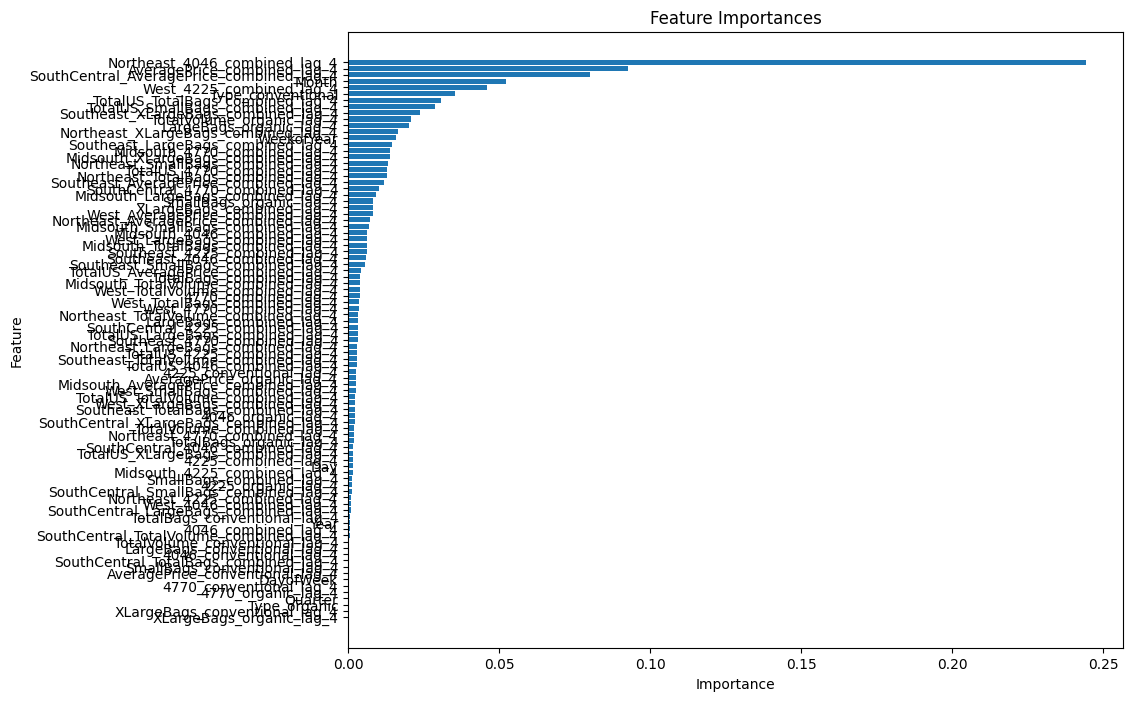

In [ ]:
# xgb_model = model.get_raw_model()

# # Get feature importances
# feature_importances = xgb_model.feature_importances_
# feature_names = xgb_model.feature_names_in_

# # Create a DataFrame for feature importances
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# })

# # Sort the DataFrame by importance
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Plot the feature importances
# plt.figure(figsize=(10, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances')
# plt.gca().invert_yaxis()
# plt.show()

In [11]:
import datetime as dt
import pandas as pd
import numpy as np
dates = pd.Series([dt.date(year=2023, month= 12, day = 1), dt.date(year=2023, month=12, day = 15)])
dates = pd.to_datetime(dates)
date_columns = ['Year', 'Month', 'Day', 'DayofWeek', 'WeekofYear', 'Quarter']

model_test_df.loc[:, ~model_test_df.columns.isin(date_columns)] = np.nan

/tmp/ipykernel_81217/2012266790.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  model_test_df.loc[:, ~model_test_df.columns.isin(date_columns)] = np.nan
/tmp/ipykernel_81217/2012266790.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  model_test_df.loc[:, ~model_test_df.columns.isin(date_columns)] = np.nan


In [ ]:
import requests
# Replace with your API host and port if different
url = "http://127.0.0.1:8000/predict/Albany"

payload_df = X.copy()

# payload_df['Year'] = payload_df['Year'].astype('int32')
payload = payload_df.iloc[-1].to_dict()

response = requests.post(url, json=payload)

# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())